**Initialization of Salvus**

In [39]:
'''Salome Bachmann - Research Module in Applied Geophysics

Setting up a purely acoustic simulation with a point source using Salvus in homogenous media in 2D'''


# Imports (taken from salvus tutorials)
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local") # Site name given in the installation of Salvus flow
PROJECT_DIR = "simulation_pure_acoustic"
import pathlib
import numpy as np
import salvus.namespace as sn
import xarray as xr
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)



**Setup of Model domain**

In [40]:
# Setup of the model domain as a box --> IS THIS CORRECT OF SHOULD THE GEOMETRY BE DIFFERENT ???????
from xml.parsers.expat import model


d = sn.domain.dim2.BoxDomain(x0=0.0, x1=2000.0, y0=0.0, y1=1000.0) 

# Initilaize project from domain 
p = sn.Project.from_domain(path=PROJECT_DIR, domain=d, load_if_exists=True)

# Delete previous events if re-running the notebook
#p.events.delete(event_name="event_acoustic_hom")




Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-12-18 16:37:30,768] INFO: Loading project from simulation_pure_acoustic.


** Setup of acoustic (explosive source) and strain recievers **
Point vector source because from an explosion the force radiates outward from the explosion point

In [41]:
# Source setup in the center of the model domain 
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=1000.0, y=500.0, fx=1e10, fy=1e10 # fx and fy are the x and y components of the force in N I DONT KNOW WHAT VALUES THESE SHOULD BE --> RESEARCH MORE
)

# Reciever setup - strain reciebvers along the surface
recs = [
    sn.simple_config.receiver.cartesian.Point2D(
        y=1000, # Change this if recievers are buried 
        x=x,
        network_code="xx",
        station_code=f"REC{i + 1}",
        fields=["strain" ,"stress"]
    )
    for i, x in enumerate(np.linspace(1010.0, 1410.0, 10))
]

# Add sources and recievers to propject
p.add_to_project(sn.Event(event_name="event_acoustic_hom", sources=src, receivers=recs))

**Running the simulation, using parameters for snow**
Using an isotropic elastic model because there is only one material present which is assumed to be homogenous. Parameters are density of 800kg/m^3, vp of 300m/s, vs of 150m/s. Values were taken from https://tc.copernicus.org/articles/15/5805/2021/ table 2 for fresh snow

In [42]:
mc = sn.ModelConfiguration(
    background_model=sn.model.background.homogeneous.IsotropicElastic(
        rho=800.0, vp=300.0, vs=150
    )
)

**Wavelet configuration**

In [43]:
ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(center_frequency=14.5), # Center frequency is dependend on sourcve
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
        start_time_in_seconds=-0.1,
        end_time_in_seconds=0.6,
    ),
)


**Simulation configuration**

In [44]:

p.add_to_project(
    sn.SimulationConfiguration(
        name="pure_acoustic_simulation_3",
        max_frequency_in_hertz=30.0,
        elements_per_wavelength=3.0,
        model_configuration=mc,
        event_configuration=ec,
    
       
    )
)

# Launich simulation
p.simulations.launch(
    ranks_per_job=2,
    site_name="macbook",
    events=p.events.list(),
    simulation_configuration="pure_acoustic_simulation",
    delete_conflicting_previous_results=True,

)

# Waiting for all simulations to be done
p.simulations.query(block=True)

[2025-12-18 16:37:30,820] INFO: Data for 1 event(s) already exists. They will not be submitted again.
[2025-12-18 16:37:30,873] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2512181637875762_549e725517@macbook


VBox()

True

In [45]:
# # Printing the data to check which parts are there to avoid key error when plotting
# ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())

# # try to get receiver data (no trailing dot in receiver name)
# try:
#     print(
#         ed[0].get_receiver_data(
#             receiver_name="XX.REC1", receiver_field="strain"
#         )
#     )
# except KeyError as e:
#     print("Receiver not found:", e)

# # Printing the keys available in the data
# try:
#     keys = ed[0].data.keys()
# except AttributeError:
#     try:
#         keys = list(ed[0].data)
#     except Exception:
#         keys = repr(ed[0].data)



**Visualization of wavelets**

/var/folders/5f/g3nknsgx6q3f91j5rd12vp240000gn/T/ipykernel_5347/2429442770.py:2: DeprecationWarning: The method get_data_cube is deprecated and superseded by `get_waveform_data_xarray`. On xarray.DataArray, one can naturally apply selections, filters and sorting. The `get_data_cube` method will be removed in a future release.
  p.waveforms.get(data_name="pure_acoustic_simulation", events=p.events.list())[1].plot(


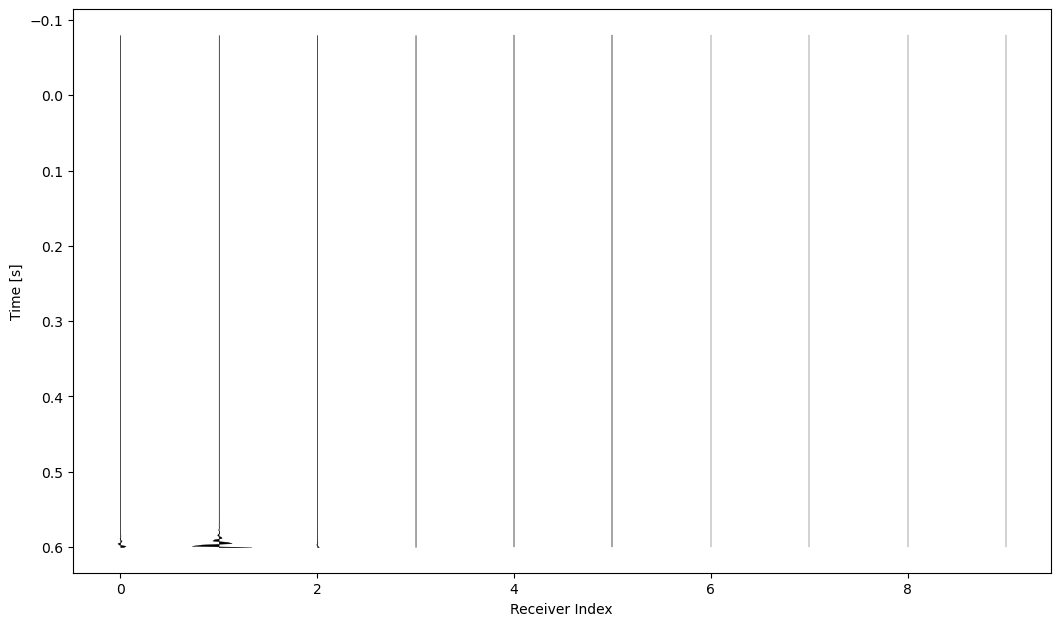

In [66]:
# Plotting a shotgather
p.waveforms.get(data_name="pure_acoustic_simulation", events=p.events.list())[1].plot(
    plot_types=("wiggles",), receiver_field="strain", component="1"
)

**PLotting the individual reciever data to see what the data contains**

3 Trace(s) in Stream:
XX.REC2..0 | 1969-12-31T23:59:59.920000Z - 1970-01-01T00:00:00.600000Z | 579.4 Hz, 395 samples
XX.REC2..1 | 1969-12-31T23:59:59.920000Z - 1970-01-01T00:00:00.600000Z | 579.4 Hz, 395 samples
XX.REC2..2 | 1969-12-31T23:59:59.920000Z - 1970-01-01T00:00:00.600000Z | 579.4 Hz, 395 samples


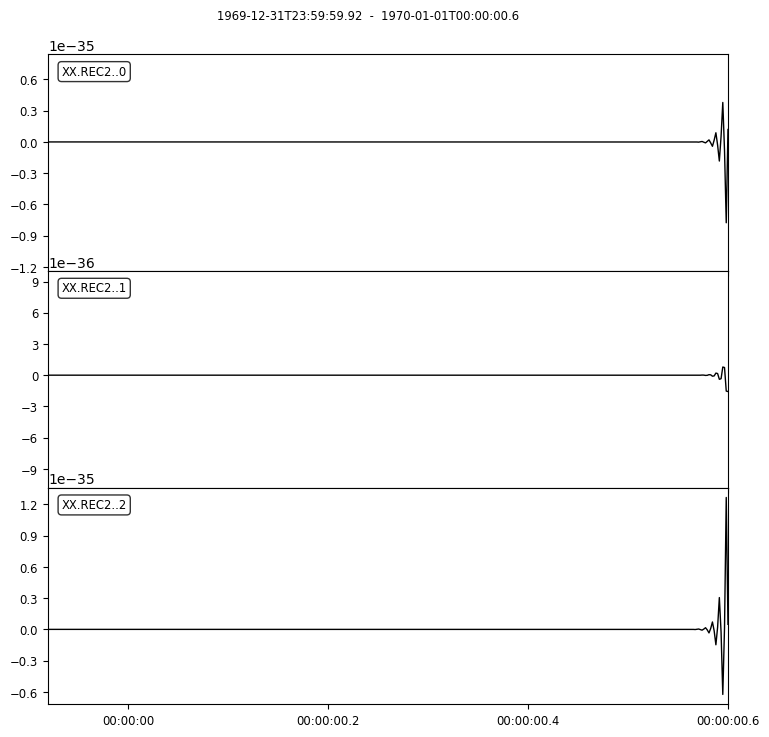

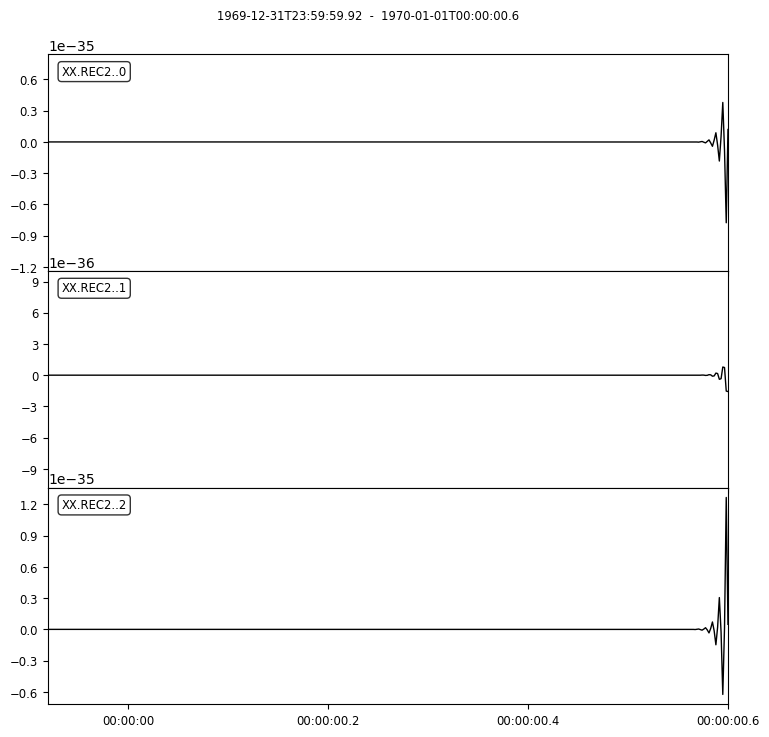

In [76]:
ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())
print(
    ed[0].get_receiver_data(
        receiver_name="XX.REC2.", receiver_field="strain"
    )
)
ed[0].get_receiver_data(
    receiver_name="XX.REC2.", receiver_field="strain"
).plot()